In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
df = pd.read_csv("../../data/data_adjustmented.csv")

In [3]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [4]:
# Time series visualization with Plotly Express
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# สร้าง time series data
ts_arl_data = pd.Series(df['รถไฟฟ้า ARL'].values, 
                   index=pd.date_range(start='2020-01-01', 
                                     periods=len(df), 
                                     freq='D'))

# แสดงข้อมูล 5 แถวแรก
print("First 5 rows:")
print(ts_arl_data.head())

# แสดงข้อมูลเชิงสถิติพื้นฐาน
print("\nBasic statistics:")
print(ts_arl_data.describe())

# เตรียมข้อมูลสำหรับ plotly
df_plot = pd.DataFrame({
    'วันที่': ts_arl_data.index,
    'ราง': ts_arl_data.values
})

# เพิ่มข้อมูลการวิเคราะห์
df_plot['เดือน'] = df_plot['วันที่'].dt.month
df_plot['วันในสัปดาห์'] = df_plot['วันที่'].dt.dayofweek
df_plot['ปี'] = df_plot['วันที่'].dt.year

# กำหนดสีธีม
colors = {
    'primary': '#69247C',
    'secondary': '#DA498D', 
    'accent': '#FAC67A',
    'background': '#2C3E50'
}

# สร้าง subplots
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=[
        '<b>การเดินทางด้วยรถรางไฟฟ้ารายวัน</b>',
        '<b>การกระจายตัวของข้อมูล</b>',
        '<b>ค่าเฉลี่ยรายเดือน</b>',
        '<b>ค่าเฉลี่ยรายวัน (วันในสัปดาห์)</b>'
    ],
    specs=[[{"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}]],
    vertical_spacing=0.12,
    horizontal_spacing=0.1
)

# 1. Time Series หลัก
fig.add_trace(
    go.Scatter(
        x=df_plot['วันที่'],
        y=df_plot['ราง'],
        mode='lines',
        name='จำนวนผู้โดยสาร',
        line=dict(color=colors['primary'], width=1.5),
        hovertemplate='<b>%{x}</b><br>จำนวนผู้โดยสาร: %{y:,.0f} คน<extra></extra>'
    ),
    row=1, col=1
)

# เพิ่ม trend line
z = np.polyfit(range(len(ts_arl_data)), ts_arl_data.values, 1)
trend_line = z[0] * np.arange(len(ts_arl_data)) + z[1]
fig.add_trace(
    go.Scatter(
        x=df_plot['วันที่'],
        y=trend_line,
        mode='lines',
        name=f'Trend: {z[0]:.2f}',
        line=dict(color=colors['secondary'], width=2, dash='dash'),
        hovertemplate='<b>Trend</b><br>%{y:,.0f} คน<extra></extra>'
    ),
    row=1, col=1
)

# 2. Histogram
fig.add_trace(
    go.Histogram(
        x=df_plot['ราง'],
        nbinsx=50,
        name='การกระจายตัว',
        marker_color=colors['accent'],
        opacity=0.7,
        hovertemplate='ช่วง: %{x:,.0f}<br>ความถี่: %{y}<extra></extra>'
    ),
    row=1, col=2
)

# เพิ่มเส้นค่าเฉลี่ยและค่ากลาง
mean_val = ts_arl_data.mean()
median_val = ts_arl_data.median()

fig.add_vline(
    x=mean_val, 
    line=dict(color='red', dash='dash', width=2),
    annotation_text=f'Mean: {mean_val:,.0f}',
    row=1, col=2
)

fig.add_vline(
    x=median_val,
    line=dict(color='orange', dash='dash', width=2), 
    annotation_text=f'Median: {median_val:,.0f}',
    row=1, col=2
)

# 3. Monthly pattern
monthly_data = df_plot.groupby('เดือน')['ราง'].mean()
month_names = ['ม.ค.', 'ก.พ.', 'มี.ค.', 'เม.ย.', 'พ.ค.', 'มิ.ย.',
               'ก.ค.', 'ส.ค.', 'ก.ย.', 'ต.ค.', 'พ.ย.', 'ธ.ค.']

fig.add_trace(
    go.Bar(
        x=month_names,
        y=monthly_data.values,
        name='ค่าเฉลี่ยรายเดือน',
        marker_color=colors['secondary'],
        opacity=0.8,
        text=[f'{v:,.0f}' for v in monthly_data.values],
        textposition='outside',
        hovertemplate='<b>%{x}</b><br>ค่าเฉลี่ย: %{y:,.0f} คน<extra></extra>'
    ),
    row=2, col=1
)

# 4. Weekly pattern
weekly_data = df_plot.groupby('วันในสัปดาห์')['ราง'].mean()
day_names = ['จันทร์', 'อังคาร', 'พุธ', 'พฤหัสบดี', 'ศุกร์', 'เสาร์', 'อาทิตย์']
bar_colors = [colors['primary'] if i < 5 else colors['accent'] for i in range(7)]

fig.add_trace(
    go.Bar(
        x=day_names,
        y=weekly_data.values,
        name='ค่าเฉลี่ยรายวัน',
        marker_color=bar_colors,
        opacity=0.8,
        text=[f'{v:,.0f}' for v in weekly_data.values],
        textposition='outside',
        hovertemplate='<b>%{x}</b><br>ค่าเฉลี่ย: %{y:,.0f} คน<extra></extra>'
    ),
    row=2, col=2
)

# ปรับแต่งกราฟ
fig.update_layout(
    title={
        'text': 'การวิเคราะห์ข้อมูลการเดินทางด้วยรถรางไฟฟ้า',
        'y': 0.98,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=28, color=colors['background'])
    },
    showlegend=False,
    height=900,
    width=1400,
    template='plotly_white',
    plot_bgcolor='white',
    paper_bgcolor='white'
)

# ปรับแต่ง axes
for row in range(1, 3):
    for col in range(1, 3):
        fig.update_xaxes(
            showgrid=True,
            gridwidth=1,
            gridcolor='#E5E8E8',
            tickfont=dict(size=11),
            row=row, col=col
        )
        fig.update_yaxes(
            showgrid=True,
            gridwidth=1,
            gridcolor='#E5E8E8',
            tickfont=dict(size=11),
            tickformat=',d',
            row=row, col=col
        )

# ปรับแต่งชื่อแกน
fig.update_xaxes(title_text='วันที่', title_font=dict(size=14), row=1, col=1)
fig.update_xaxes(title_text='จำนวนผู้โดยสาร (คน)', title_font=dict(size=14), row=1, col=2)
fig.update_xaxes(title_text='เดือน', title_font=dict(size=14), row=2, col=1)
fig.update_xaxes(title_text='วันในสัปดาห์', title_font=dict(size=14), row=2, col=2)

fig.update_yaxes(title_text='จำนวนผู้โดยสาร (คน)', title_font=dict(size=14), row=1, col=1)
fig.update_yaxes(title_text='ความถี่', title_font=dict(size=14), row=1, col=2)
fig.update_yaxes(title_text='จำนวนผู้โดยสารเฉลี่ย (คน)', title_font=dict(size=14), row=2, col=1)
fig.update_yaxes(title_text='จำนวนผู้โดยสารเฉลี่ย (คน)', title_font=dict(size=14), row=2, col=2)

# แสดงกราฟ
fig.show()

# แสดงข้อมูลสถิติเพิ่มเติม
print(f"\n📊 สถิติเพิ่มเติม:")
print(f"• ค่าสูงสุด: {ts_arl_data.max():,.0f} คน (วันที่ {ts_arl_data.idxmax().strftime('%Y-%m-%d')})")
print(f"• ค่าต่ำสุด: {ts_arl_data.min():,.0f} คน (วันที่ {ts_arl_data.idxmin().strftime('%Y-%m-%d')})")
print(f"• ค่าเฉลี่ย: {ts_arl_data.mean():,.0f} คน")
print(f"• ส่วนเบี่ยงเบนมาตรฐาน: {ts_arl_data.std():,.0f} คน")
print(f"• ค่ากลาง: {ts_arl_data.median():,.0f} คน")
print(f"• ช่วงข้อมูล: {ts_arl_data.max() - ts_arl_data.min():,.0f} คน")
print(f"• ค่าเฉลี่ยวันธรรมดา: {weekly_data[:5].mean():,.0f} คน")
print(f"• ค่าเฉลี่ยวันหยุดสุดสัปดาห์: {weekly_data[5:].mean():,.0f} คน")

First 5 rows:
2020-01-01    48790
2020-01-02    65090
2020-01-03    69465
2020-01-04    53304
2020-01-05    50992
Freq: D, dtype: int64

Basic statistics:
count      2073.000000
mean      48990.689822
std       20841.496498
min        4355.000000
25%       32114.000000
50%       50886.000000
75%       68047.000000
max      101641.000000
dtype: float64



📊 สถิติเพิ่มเติม:
• ค่าสูงสุด: 101,641 คน (วันที่ 2025-01-31)
• ค่าต่ำสุด: 4,355 คน (วันที่ 2021-07-25)
• ค่าเฉลี่ย: 48,991 คน
• ส่วนเบี่ยงเบนมาตรฐาน: 20,841 คน
• ค่ากลาง: 50,886 คน
• ช่วงข้อมูล: 97,286 คน
• ค่าเฉลี่ยวันธรรมดา: 53,207 คน
• ค่าเฉลี่ยวันหยุดสุดสัปดาห์: 38,443 คน


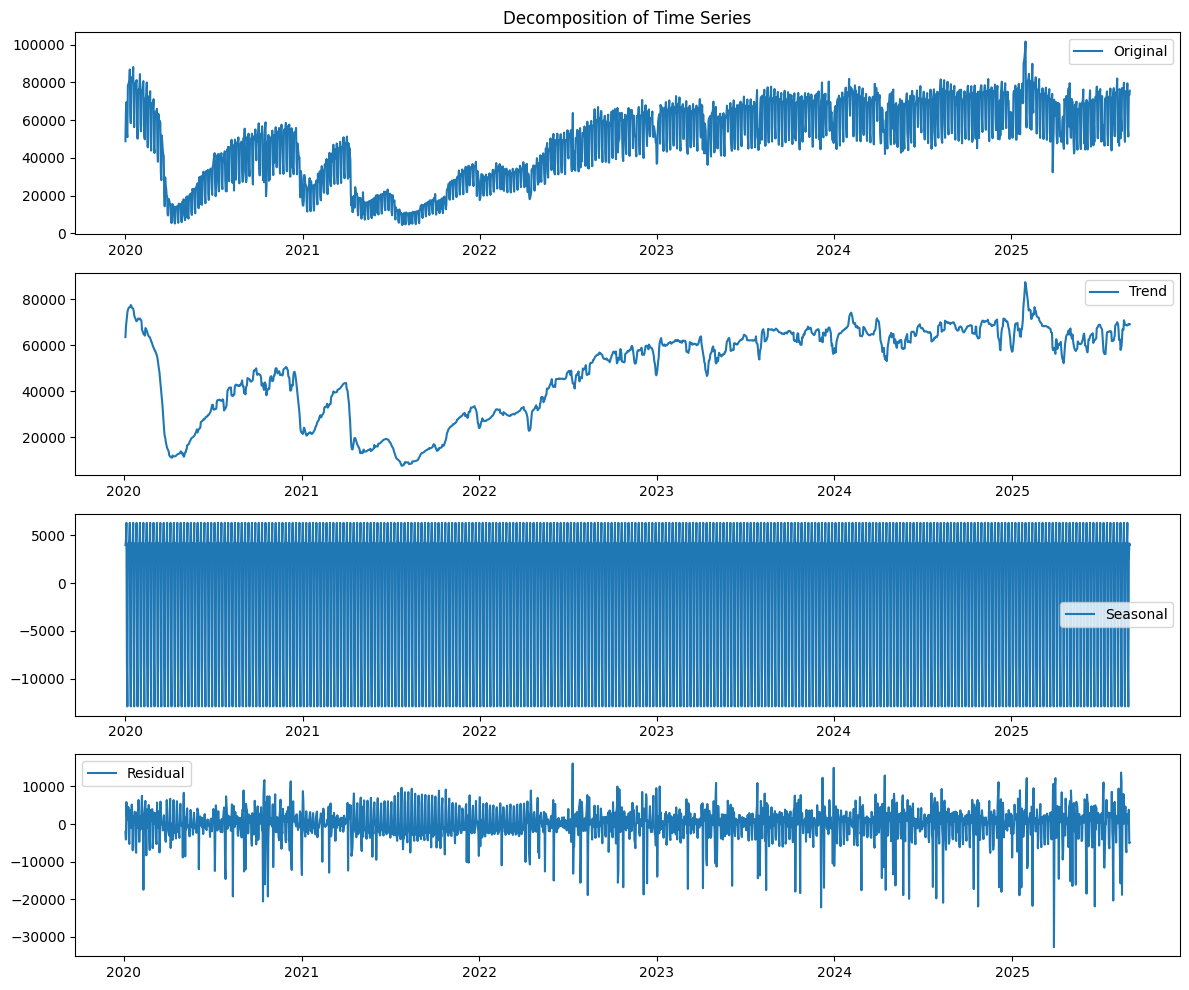

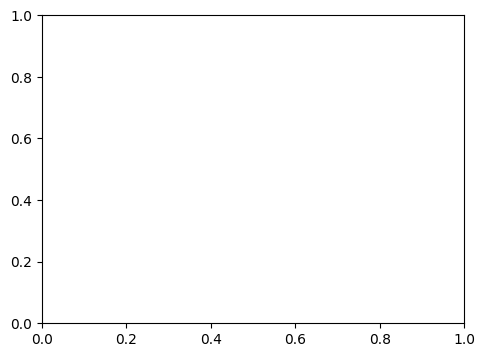

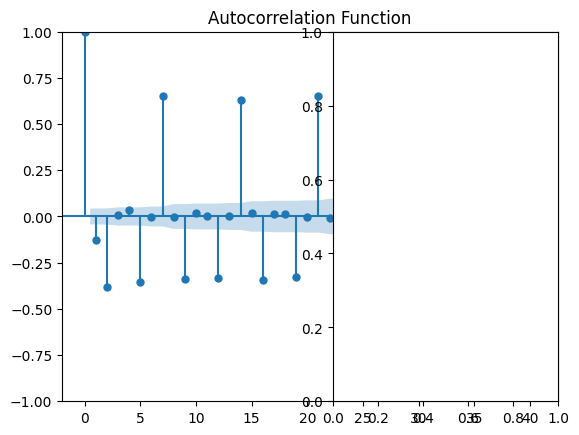

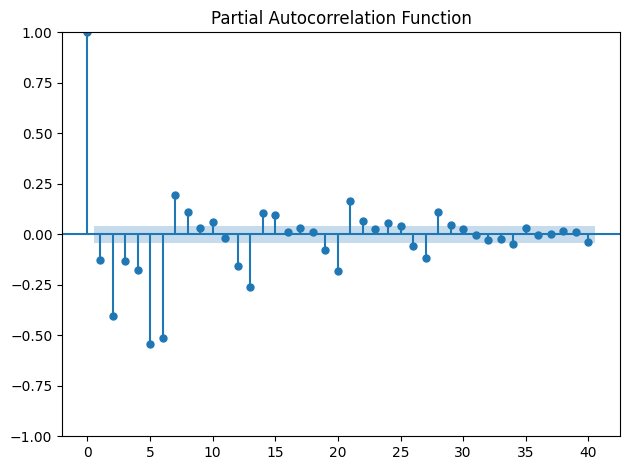


Augmented Dickey-Fuller Test:
ADF Statistic: -10.058834094910718
p-value: 1.3503810391451095e-17
Critical values:
	1%: -3.4335517248444334
	5%: -2.8629543667432555
	10%: -2.567522945522803


In [5]:
# 1. การวิเคราะห์แนวโน้มและความผันผวน
from statsmodels.tsa.seasonal import seasonal_decompose

# # Decompose time series
decomposition = seasonal_decompose(ts_arl_data, period=7)  # period=7 for weekly seasonality

# Plot decomposition
plt.figure(figsize=(12, 10))
plt.subplot(411)
plt.plot(ts_arl_data, label='Original')
plt.legend()
plt.title('Decomposition of Time Series')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()

# ACF และ PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

ts_arl_diff = np.diff(ts_arl_data, n=1)  
# plt.figure(figsize=(12, 10))
# plt.subplot(411)
# plt.plot(ts_road_diff, label='Original')
# plt.legend()
# plt.title('Differencing of Time Series')


plt.figure(figsize=(12, 4))

plt.subplot(121)
plot_acf(ts_arl_diff, lags=40, title='Autocorrelation Function')

plt.subplot(122)
plot_pacf(ts_arl_diff, lags=40, title='Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

# 5. Checking stationarity
from statsmodels.tsa.stattools import adfuller

print('\nAugmented Dickey-Fuller Test:')
result = adfuller(ts_arl_diff)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

In [6]:

train, test = ts_arl_data[:2066], ts_arl_data[2066:]
print(len(train), len(test))


2066 7


In [7]:
# Import SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

P, D, Q, m = 2, 1, 2, 7  # Seasonal parameters 

# สร้างและ fit SARIMA model
model_sarima = SARIMAX(
    train,
    order=(P, D, Q),
    seasonal_order=(P, D, Q, m),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results_sarima = model_sarima.fit()


SARIMA Model Evaluation Metrics:
RMSE: 2433.5701
MAPE: 2.9429%


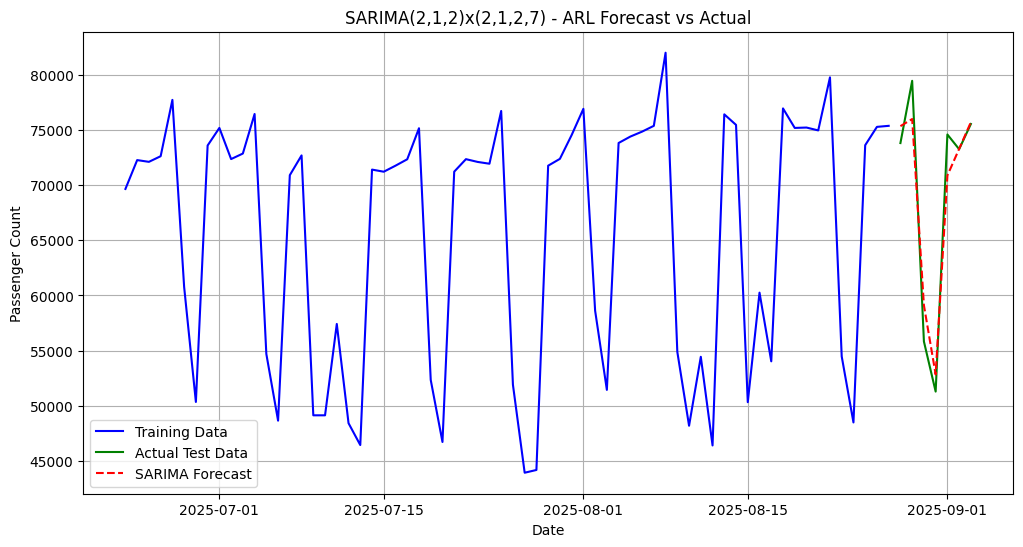

In [8]:
# ทำนายค่าสำหรับชุดทดสอบ
forecast_sarima = results_sarima.forecast(steps=len(test))

# คำนวณค่าความผิดพลาด
mae_sarima = mean_absolute_error(test, forecast_sarima)
rmse_sarima = np.sqrt(mean_squared_error(test, forecast_sarima))
mape_sarima = mape(test, forecast_sarima)

print("\nSARIMA Model Evaluation Metrics:")
print(f"RMSE: {rmse_sarima:.4f}")
print(f"MAPE: {mape_sarima:.4f}%")

# สร้างกราฟแสดงผลการทำนาย
plt.figure(figsize=(12, 6))
plt.plot(ts_arl_data[2000:2066].index, ts_arl_data[2000:2066], label='Training Data', color='blue')
plt.plot(test.index, test, label='Actual Test Data', color='green')
plt.plot(test.index, forecast_sarima, label='SARIMA Forecast', color='red', linestyle='--')

plt.title(f'SARIMA({P},{D},{Q})x({P},{D},{Q},{m}) - ARL Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Passenger Count')
plt.legend()
plt.grid(True)
plt.show()



# DEMO

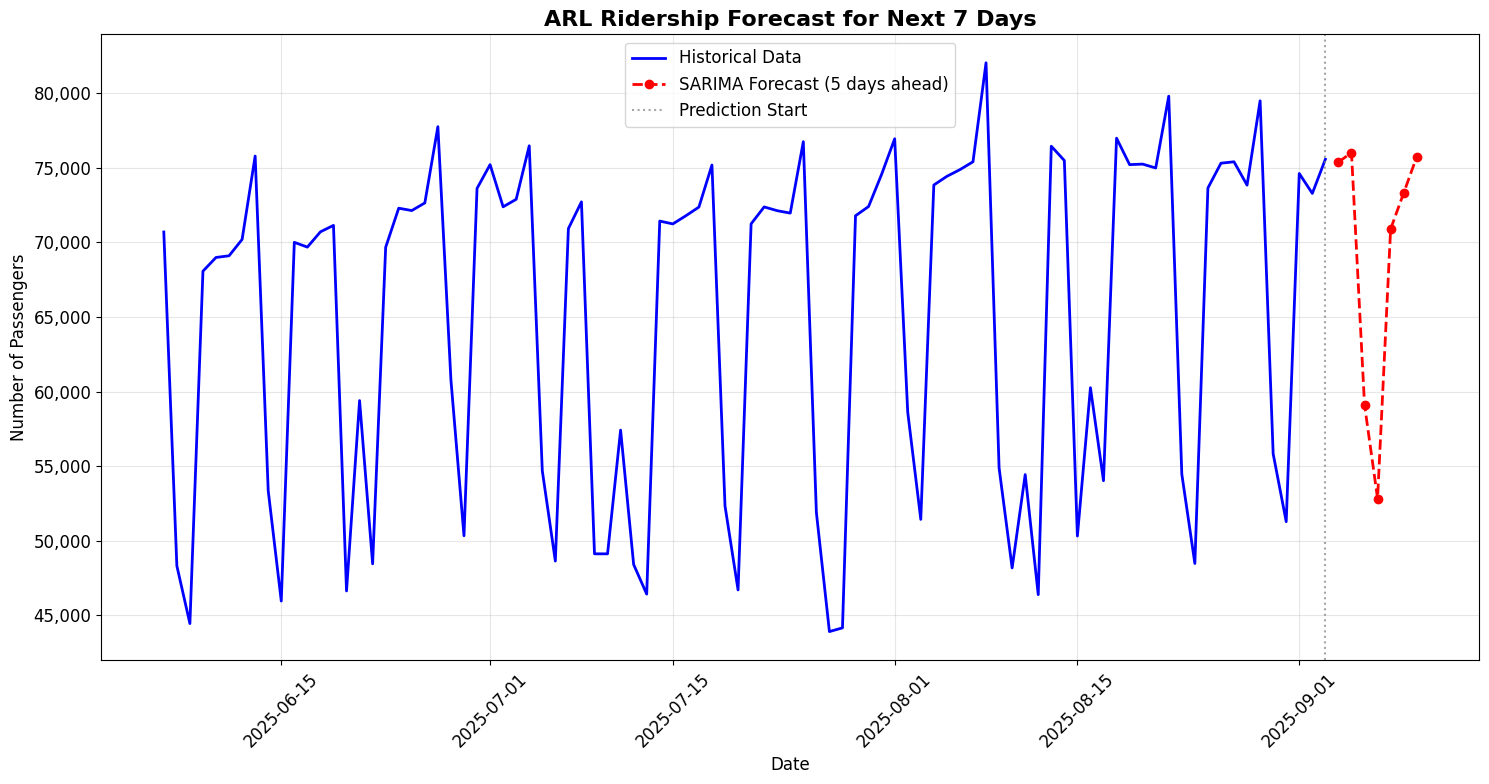

📊 ARL Ridership Prediction for Next 7 Days
Day 1: 04/09/2025 (Thursday) - 75,365 passengers
Day 2: 05/09/2025 (Friday) - 76,009 passengers
Day 3: 06/09/2025 (Saturday) - 59,111 passengers
Day 4: 07/09/2025 (Sunday) - 52,833 passengers
Day 5: 08/09/2025 (Monday) - 70,886 passengers
Day 6: 09/09/2025 (Tuesday) - 73,302 passengers
Day 7: 10/09/2025 (Wednesday) - 75,727 passengers

📈 Prediction Statistics:
• Average: 69,033 passengers/day
• Maximum: 76,009 passengers
• Minimum: 52,833 passengers
• Total (5 days): 483,234 passengers


In [14]:
# ทำนายค่า 5 วันถัดไป
forecast_steps = 7
forecast_sarima = results_sarima.forecast(steps=forecast_steps)

# สร้างวันที่สำหรับการทำนาย (5 วันถัดไปจากข้อมูลล่าสุด)
last_date = ts_arl_data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), 
                            periods=forecast_steps, 
                            freq='D')

# ตั้งค่า matplotlib สำหรับแก้ปัญหาภาษาไทย
import matplotlib
matplotlib.rcParams['font.family'] = ['DejaVu Sans', 'Tahoma', 'Microsoft Sans Serif']
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Tahoma', 'Microsoft Sans Serif']
plt.rcParams['axes.unicode_minus'] = False

# สร้างกราฟแสดงผลการทำนาย
plt.figure(figsize=(15, 8))

# แสดงข้อมูลจริงย้อนหลัง 90 วัน
historical_days = 90
historical_data = ts_arl_data[-historical_days:]
plt.plot(historical_data.index, historical_data, 
         label='Historical Data', color='blue', linewidth=2)

# แสดงการทำนาย 5 วันถัดไป
plt.plot(future_dates, forecast_sarima, 
         label='SARIMA Forecast (5 days ahead)', 
         color='red', linewidth=2, linestyle='--', marker='o', markersize=6)

# เส้นแบ่งระหว่างข้อมูลจริงและการทำนาย
plt.axvline(x=last_date, color='gray', linestyle=':', alpha=0.7, 
            label='Prediction Start')

plt.title(f'ARL Ridership Forecast for Next {forecast_steps} Days', 
          fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Passengers', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

# จัดรูปแบบแกน y
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

plt.show()

# แสดงผลการทำนาย
print("=" * 60)
print(f"📊 ARL Ridership Prediction for Next {forecast_steps} Days")
print("=" * 60)
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for i, (date, value) in enumerate(zip(future_dates, forecast_sarima), 1):
    day_name = day_names[date.weekday()]
    print(f"Day {i}: {date.strftime('%d/%m/%Y')} ({day_name}) - {value:,.0f} passengers")

print(f"\n📈 Prediction Statistics:")
print(f"• Average: {forecast_sarima.mean():,.0f} passengers/day")
print(f"• Maximum: {forecast_sarima.max():,.0f} passengers")
print(f"• Minimum: {forecast_sarima.min():,.0f} passengers")
print(f"• Total (5 days): {forecast_sarima.sum():,.0f} passengers")
print("=" * 60)

In [10]:
# บันทึกผลการทำนายลงไฟล์ CSV
def save_sarima_predictions(future_dates, forecast_values, filename="sarima_arl_predictions.csv"):
    """
    บันทึกผลการทำนาย SARIMA ลงไฟล์ CSV
    """
    # สร้าง DataFrame
    day_names_en = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day_names_th = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    df_predictions = pd.DataFrame({
        'Date': future_dates.strftime('%Y-%m-%d'),
        'Day_of_Week': [day_names_en[date.weekday()] for date in future_dates],
        'Date_Thai_Format': future_dates.strftime('%d/%m/%Y'),
        'Predicted_Passengers': forecast_values.astype(int),
        'Model': 'SARIMA'
    })
    
    # บันทึกลงไฟล์
    df_predictions.to_csv(filename, index=False, encoding='utf-8-sig')
    print(f"📄 Successfully saved predictions to {filename}")
    print(f"Number of rows: {len(df_predictions)}")
    
    return df_predictions

# บันทึกผลการทำนาย
df_saved = save_sarima_predictions(future_dates, forecast_sarima)
print("\n📋 Sample of saved data:")
print(df_saved.to_string(index=False))

📄 Successfully saved predictions to sarima_arl_predictions.csv
Number of rows: 5

📋 Sample of saved data:
      Date Day_of_Week Date_Thai_Format  Predicted_Passengers  Model
2025-09-04    Thursday       04/09/2025                 75364 SARIMA
2025-09-05      Friday       05/09/2025                 76009 SARIMA
2025-09-06    Saturday       06/09/2025                 59111 SARIMA
2025-09-07      Sunday       07/09/2025                 52833 SARIMA
2025-09-08      Monday       08/09/2025                 70886 SARIMA


findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Fo

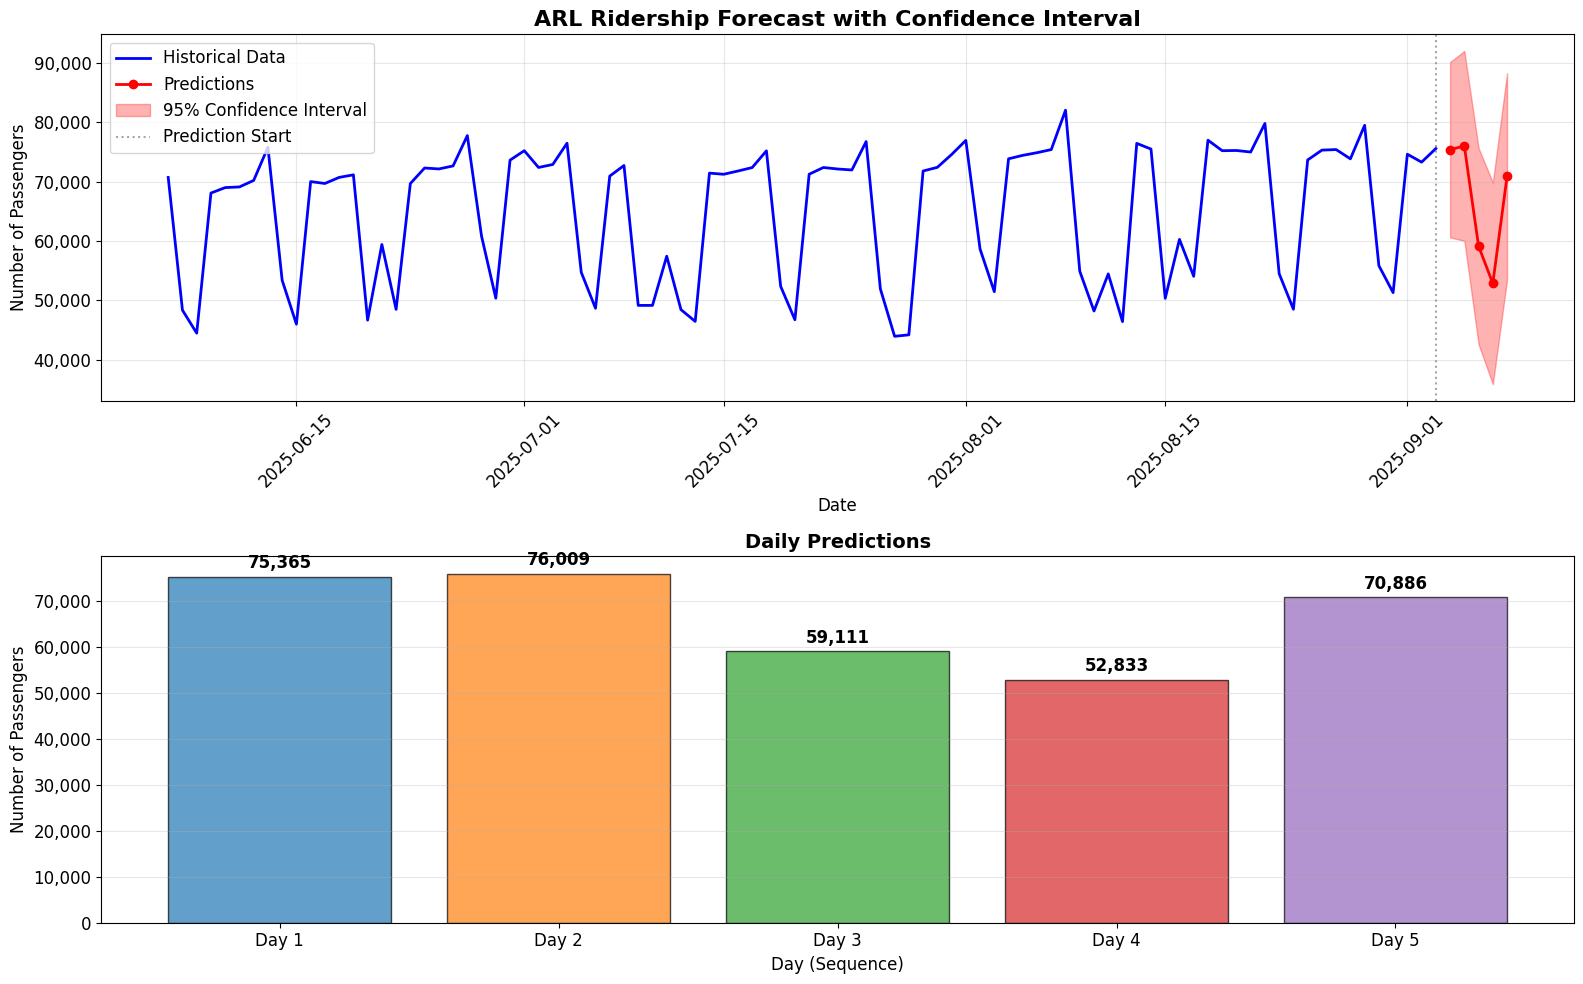

📊 Forecast with 95% Confidence Interval
Date         Prediction   Lower 95%       Upper 95%      
--------------------------------------------------------------------------------
04/09/2025       75,365        60,581        90,149
05/09/2025       76,009        60,012        92,006
06/09/2025       59,111        42,561        75,662
07/09/2025       52,833        35,842        69,824
08/09/2025       70,886        53,486        88,287


In [11]:
# การทำนายพร้อม Confidence Interval (English Version)
def forecast_with_confidence_en(model_results, steps=5, alpha=0.05):
    """
    Forecast with confidence interval (English version)
    
    Parameters:
    - model_results: SARIMA model results
    - steps: number of days to forecast
    - alpha: confidence level (0.05 = 95% confidence)
    """
    # Forecast with confidence interval
    forecast_result = model_results.get_forecast(steps=steps)
    forecast_mean = forecast_result.predicted_mean
    forecast_ci = forecast_result.conf_int(alpha=alpha)
    
    return forecast_mean, forecast_ci

# ทำนายพร้อม confidence interval
forecast_mean, forecast_ci = forecast_with_confidence_en(results_sarima, steps=5)

# ตั้งค่า matplotlib
import matplotlib
matplotlib.rcParams['font.family'] = ['DejaVu Sans', 'Arial Unicode MS', 'Tahoma', 'Microsoft Sans Serif']
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['axes.unicode_minus'] = False

# สร้างกราฟที่แสดง confidence interval
plt.figure(figsize=(16, 10))

# กราฟหลัก
plt.subplot(2, 1, 1)
historical_days = 90
historical_data = ts_arl_data[-historical_days:]

plt.plot(historical_data.index, historical_data, 
         label='Historical Data', color='blue', linewidth=2)
plt.plot(future_dates, forecast_mean, 
         label='Predictions', color='red', linewidth=2, marker='o', markersize=6)

# แสดง confidence interval
plt.fill_between(future_dates, 
                forecast_ci.iloc[:, 0], 
                forecast_ci.iloc[:, 1], 
                color='red', alpha=0.3, label='95% Confidence Interval')

plt.axvline(x=last_date, color='gray', linestyle=':', alpha=0.7, 
            label='Prediction Start')

plt.title('ARL Ridership Forecast with Confidence Interval', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Passengers', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

# กราฟรายละเอียดการทำนาย
plt.subplot(2, 1, 2)
bars = plt.bar(range(1, 6), forecast_mean, 
               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'],
               alpha=0.7, edgecolor='black')

# เพิ่มค่าบนแท่งกราฟ
for i, (bar, value) in enumerate(zip(bars, forecast_mean)):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1000,
             f'{value:,.0f}', ha='center', va='bottom', fontweight='bold')

plt.title('Daily Predictions', fontsize=14, fontweight='bold')
plt.xlabel('Day (Sequence)', fontsize=12)
plt.ylabel('Number of Passengers', fontsize=12)
plt.xticks(range(1, 6), [f'Day {i}' for i in range(1, 6)])
plt.grid(True, alpha=0.3, axis='y')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

plt.tight_layout()
plt.show()

# แสดงผลการทำนายพร้อม confidence interval
print("=" * 80)
print("📊 Forecast with 95% Confidence Interval")
print("=" * 80)
print(f"{'Date':<12} {'Prediction':<12} {'Lower 95%':<15} {'Upper 95%':<15}")
print("-" * 80)
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for i, (date, mean_val, ci_low, ci_high) in enumerate(
    zip(future_dates, forecast_mean, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1]), 1):
    day_name = day_names[date.weekday()]
    print(f"{date.strftime('%d/%m/%Y'):<12} {mean_val:>10,.0f} {ci_low:>13,.0f} {ci_high:>13,.0f}")

print("=" * 80)